In [1]:
%matplotlib inline


### 转移学习
**作者**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

在本教程中，你将学习如何使用转移学习训练网络。更多的转移学习在`cs231n
notes <https://cs231n.github.io/transfer-learning/>`

记录这些日志，

    实际上，一般不会从随机初始化来从头训练卷积神经网络，因为一般很少有相对充足的数据。而且
    一般在非常大的数据集上预训练一个卷积网络（例如ImageNet包括1.200,000个图像，共有10个
    类别），然后使用卷积网络作为初始值和固定特征提取器来实现感兴趣的任务。

这里有两个主要的转移学习场景，如下所示：

-  **微调卷积网络**: 与随机初始化不同，我们使用预训练好的网络来初始化网络，例如已经在
   imagenet1000类数据集总已经训练好的参数值。然后进行正常训练。
-  **把卷积网络作为固定的特征提取器**: 这里我们会固化网络的所有权值，除了最后一层全链
   接层。这个最后的全连接将会被新的随机权值初始化的层替换，并被进行训练。

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 交互模型

### 载入数据

我们使用torchvision和torch.utils.data包来加载数据。

这里我门要解决的问题是训练一个模型来分辨**蚂蚁**和**蜜蜂**。我们大约有120张训练图像分别
应用于蚂蚁和蜜蜂。也有75个验证用的图像用于每一类。当然，这是一个非常小数据集，对于这个数据集
如果重新训练，其泛化能力将很有限。因此我们使用转移学习，我们应该可以泛化的很好。

这个数据集是Imagenet数据集中的非常小的子集。

.. 笔记 ::
   下载数据到这里
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   并且解压到当前目录。



In [2]:
# 用于训练的数据扩展和归一化
# 仅仅用于验证的归一化
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 可视化一些图像

让我们来可视化一些图像，来更好的理解数据扩展

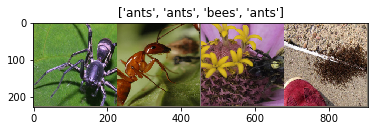

In [3]:
def imshow(inp, title=None):
    """显示张量。"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 停止一个比特来更新画图

# 得到一批训练数据
inputs, classes = next(iter(dataloaders['train']))

# 从取出的一批数据得到一个格子
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 训练模型

现在，让我们写一个通过函数来训练一个模型。这里我们描述：

-  学习率策略
-  保存最佳的模型

接下来，参数``scheduler``是一个来源``torch.optim.lr_scheduler``的学习速率策略对象。

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        # 每一轮都有一个训练和验证
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # 设置模式为训练模式
            else:
                model.eval()   # 设置模式为验证模式

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 参数梯度置零
                optimizer.zero_grad()

                # 如果仅仅训练跟踪前向运算过程
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 反馈+优化仅仅用于训练过程
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计量
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 深度拷贝模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最有模型权值
    model.load_state_dict(best_model_wts)
    return model

### 可视化模型预测

显示一些图片预测结果的通用函数

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 微调卷积模型

加载预训练模型和复位最后的全连接层。

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 观察所有都进行优化的情况
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7轮按照0.1的比例降低学习率
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/zhangxin/.torch/models/resnet18-5c106cde.pth
100.0%


# 训练和评估

在CPU上需要运行15-25分钟，在GPU上，运行时间少于1分钟。

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6393 Acc: 0.6803
val Loss: 0.3103 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5634 Acc: 0.7705
val Loss: 0.2654 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.5249 Acc: 0.7582
val Loss: 0.2019 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.6183 Acc: 0.7623
val Loss: 0.3992 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.5248 Acc: 0.7910
val Loss: 0.5111 Acc: 0.8301

Epoch 5/24
----------
train Loss: 0.5244 Acc: 0.8156
val Loss: 0.5938 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.5755 Acc: 0.7910
val Loss: 0.4005 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3004 Acc: 0.8770
val Loss: 0.2829 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.4264 Acc: 0.8525
val Loss: 0.1978 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2995 Acc: 0.8730
val Loss: 0.2397 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3635 Acc: 0.8566
val Loss: 0.2092 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2559 Acc: 0.8893
val Loss: 0.2115 Acc: 0.9346

Ep

In [ ]:
visualize_model(model_ft)

### 将卷积网络设为固定特征提取器

这里除了最后一层，固定住网络的其它层。我们需要设置``requires_grad == False``来固定参数
不在``backward()``里计算梯度

你可以阅读更多从文档`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`

In [8]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 新构造模型的参数默认认为requires_grad=True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 仅仅观察最后一层怎么优化。
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 每7轮按照0.1的比例降低学习率
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 训练和评估

和前面场景相比，在CPU上花的时间要少一般。对于大多数网络而言，不需要计算梯度。但是前向传播是必须要计算的。

In [9]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6522 Acc: 0.6598
val Loss: 0.2443 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4834 Acc: 0.7541
val Loss: 0.1635 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4055 Acc: 0.8238
val Loss: 0.1485 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4239 Acc: 0.8197
val Loss: 0.3124 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4170 Acc: 0.8279
val Loss: 0.1746 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.5121 Acc: 0.7828
val Loss: 0.2180 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3324 Acc: 0.8975
val Loss: 0.1641 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.4105 Acc: 0.8402
val Loss: 0.1697 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3835 Acc: 0.8361
val Loss: 0.1550 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3855 Acc: 0.8402
val Loss: 0.1773 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3886 Acc: 0.8402
val Loss: 0.1687 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4191 Acc: 0.8156
val Loss: 0.1721 Acc: 0.9346

Ep

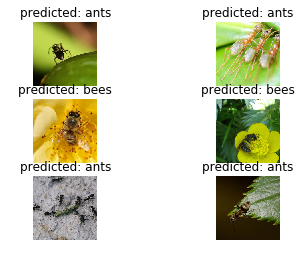

In [10]:
visualize_model(model_conv)

plt.ioff()
plt.show()